# Sentiment Classification for Tweets

In this exercise, we will use some conventional classification techniques to infer the opinion polarity a tweet carries. We will go through data preprocessing, model construction, and model validation.

### Data Loading & Preparation

First, let's load the data from the folder's features.csv file. 

You should expect the file format to be:
Label, User ID, Tweet Time Written, Tweet Text

Label annotations:

-1: negative 495 tweets 

1: positive 455 tweets 

2: neutral/irrelevant 3633 tweets

We will be working with classification with three classes: negative, positive, and neutral/irrelevant tweets

In [1]:
import csv

data = list(csv.reader(open('./features.csv', 'rU')))

We will preprocess data by performing stemming to the words. The purpose is to collapse different forms of the same word into one slot to refrain from data/feature sparsity.

Caveat: Twitter text usage is quite fluid, and sometimes words with repetitive characters carries semantic meanings. Such subtleties may affect sentiment classification.

Often, indicative features may include emoticons, punctuations (exclamation+question marks), length of a word, capitalization, hashtags, to name a few.

In [2]:
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()

words = [' '.join([stemmer.stem(w.decode('utf-8')).encode('utf-8') for w in d[3].split() ]) for d in data]

### the above is a list comprehension way of combine several steps into one, a procedural way is follows ###
# words = []
# # for each data sample in the dataset
# for d in data:
#     # split the tweet text into space delimited tokens
#     tmp = []
#     for w in d[3].split(): 
#         # returns the stemmed word for word w, note that we need to decode the original encoding for nltk to operate
#         stemmed = stemmer.stem(w.decode('utf-8'))
#         # after operation, we encode the string back
#         tmp.append(stemmed.encode('utf-8'))
#     # ' '.join([string array]) is a way to concatanate array of string
#     result_str = ' '.join(tmp) 
#     words.append(result_str)

Invoke the data into sklearn format including label matrix and data matrix

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Obtain label matrix
labels = np.array([int(d[0]) for d in data])

# Obtain bag of words data matrix
vectorizer = CountVectorizer(dtype=float)
X = vectorizer.fit_transform(words)

Also, for evaluation of the models, it is important to come up with dataset splits to prevent model overfitting the dataset that is being trained on. In this case, we use randomized k-fold cross validation, with setting k=5.

Caveat: For dataset that has serial correlation over time, it might not be wise to create validation dataset before training dataset (or scramble up time stamps), which may create "hindsight" effects

In [4]:
from sklearn.cross_validation import StratifiedKFold

skf = StratifiedKFold(labels, n_folds=5)

### Building Models

Now let's start playing with several classification algorithms

##### Naive Bayes

Naive Bayes assumes independence between features. 

reference: http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

In [74]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# declares a model instance
mnb = MultinomialNB(alpha = 0.1)

acc_nb = []
conf_nb = np.array([])
for train_index, test_index in skf:
    # for each fold in the dataset split, train the model according the training design matrix and label matrix
    mnb.fit(X[train_index], labels[train_index])
    # obtain the predicted labels for testing dataset
    pred = mnb.predict(X[test_index])
    acc_nb.append(accuracy_score(labels[test_index], pred, normalize=True))
    conf_nb = confusion_matrix(labels[test_index], pred)

# print prediction accuracy
print "Naive Bayes Prediction Accuracy:"
print sum(acc_nb)/5.0

Naive Bayes Prediction Accuracy:
0.663392351174


Confusion Matrix for Naive Bayes:


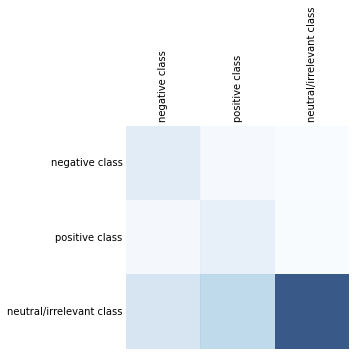

In [75]:
# visualize through heat map
%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt

def plot_heatmap(conf):
    # Plot it out
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(conf, cmap=plt.cm.Blues, alpha=0.8)
    
    # Format
    fig = plt.gcf()
    fig.set_size_inches(4, 4)
    
    # turn off the frame
    ax.set_frame_on(False)
    
    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(conf.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(conf.shape[1]) + 0.5, minor=False)
    
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    # Set the labels
    hlabels = [
    'negative class', 'positive class', 'neutral/irrelevant class']
    ax.set_xticklabels(hlabels, minor=False)
    ax.set_yticklabels(hlabels, minor=False)

    # rotate the
    plt.xticks(rotation=90)
    
    ax.grid(False)

    # Turn off all the ticks
    ax = plt.gca()

    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

# print confusion matrix for fold 5
print "Confusion Matrix for Naive Bayes:"
plot_heatmap(conf_nb)

##### Linear Kernel Support Vector Machine

For this example, we will use linear kernel for SVM. 

reference: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

SVM employs several parameters, we will be using 

SVM Prediction Accuracy:
0.831369140876
Confusion Matrix for SVM:


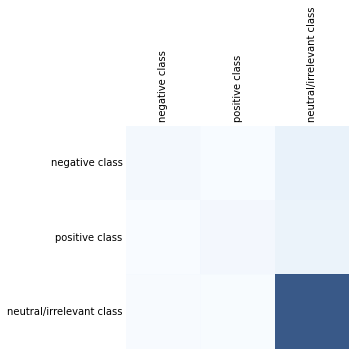

In [76]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import normalize
X1 = normalize(X, axis=0)

#svm = SVC()
svm = LinearSVC()

acc_svm = []
conf_svm = np.array([])
for train_index, test_index in skf:
    # for each fold in the dataset split, train the model according the training design matrix and label matrix
    svm.fit(X1[train_index], labels[train_index])
    # obtain the predicted labels for testing dataset
    pred = svm.predict(X1[test_index])
    acc_svm.append(accuracy_score(labels[test_index], pred, normalize=True))
    conf_svm = confusion_matrix(labels[test_index], pred)

# print prediction accuracy
print "SVM Prediction Accuracy:"
print sum(acc_svm)/5.0
# print confusion matrix for fold 5
print "Confusion Matrix for SVM:"
plot_heatmap(conf_svm)

##### Extra Tree Random Forest Classifiers

Random Forest Classifier is among one of the popular ensembles models for classification and regression. 

Note: This script might take a bit longer to run (expect ~5 min runtime).

0.84031420095
Confusion Matrix for Random Forest Classifier


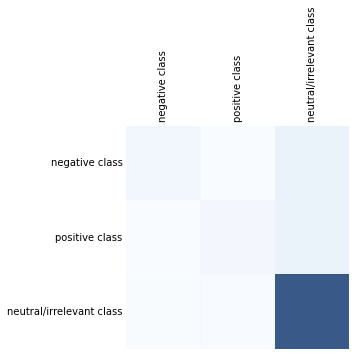

In [71]:
from sklearn.ensemble import ExtraTreesClassifier

gbrt = ExtraTreesClassifier(n_estimators=100, n_jobs=4)

acc_gbrt = []
conf_gbrt = np.array([])
for train_index, test_index in skf:
    # for each fold in the dataset split, train the model according the training design matrix and label matrix
    gbrt.fit(X[train_index].toarray(), labels[train_index])
    # obtain the predicted labels for testing dataset
    pred = gbrt.predict(X[test_index].toarray())
    acc_gbrt.append(accuracy_score(labels[test_index], pred, normalize=True))
    conf_gbrt = confusion_matrix(labels[test_index], pred)

# print prediction accuracy
print sum(acc_gbrt)/5.0
# print confusion matrix for fold 5
print "Confusion Matrix for Random Forest Classifier"
plot_heatmap(conf_gbrt)

##### Compare Across Models

Let's map the cross validation accuracy across the three models in examination:

With Matplotlib figure specification:

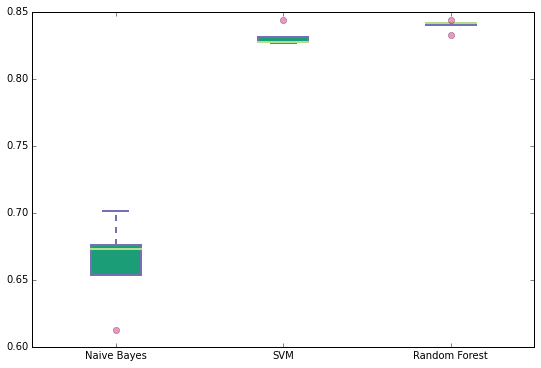

In [78]:
# define function to style box plot
def style_box(bp):
    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#1b9e77' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)
    
    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)
    
    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)
    
    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

# set data to plot the box plot
data_to_plot = [acc_nb, acc_svm, acc_gbrt]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)
ax.set_xticklabels(['Naive Bayes', 'SVM', 'Random Forest'])

style_box(bp)

fig.savefig('fig1.png', bbox_inches='tight')

fig.show()

So as we can see, the Random Forest model seems to be a good candidate for classifying sentiment of this particular set of tweets

### Other Practical Issues (Overfitting, Parameter Selection, etc.)

Now let us focus on the SVM example and debug. 

Because of the sheer amount of irrelevant/neutral samples in the dataset, and that the features aren't discriminative enough for the model to confidently predict positive or negative, the model may be susceptible to predict class 2. If we just go by default setting, the results may be unreliable.

##### Issue 1: Parameter Selection

How about we alter the parameters?

It is always important to check whether the parameters you set for the model are the optimal set. Very often, the performance depends on the particular model and dataset, so it would make sense to test the parameter set in your validation set.

*Note: It's not necessary to run the script (takes a while to run), the figure should show parameter search result

In [87]:
from sklearn.svm import SVC
cur_c = 4**-5
train_acc = []
test_acc = []
for c in range(24):
    cur_c = cur_c*2
    #cur_e = 4**-7
    cur_e = 1.0
    for e in range(1):
        #cur_e = cur_e*4
        
        svm = LinearSVC(C=cur_c, tol=cur_e)

        acc_svm = []
        acc_svm1 = []
        conf_svm = np.array([])
        flag = True
        for train_index, test_index in skf:
            # for each fold in the dataset split, train the model according the training design matrix and label matrix
            try:
                svm.fit(X[train_index], labels[train_index])
            except Exception:
                flag = False
                break
            # obtain the predicted labels for testing dataset
            pred = svm.predict(X[train_index])
            acc_svm.append(accuracy_score(labels[train_index], pred, normalize=True))
            pred1 = svm.predict(X[test_index])
            acc_svm1.append(accuracy_score(labels[test_index], pred1, normalize=True))
            conf_svm = confusion_matrix(labels[train_index], pred)
        if not flag:
            print "not printable"
            continue
        # print prediction accuracy
        #print cur_c, cur_e, sum(acc_svm)/5.0, sum(acc_svm1)/5.0
        train_acc.append(sum(acc_svm)/5.0)
        test_acc.append(sum(acc_svm1)/5.0)
        # print confusion matrix for fold 5
        #print conf_svm
        #0.848166843657

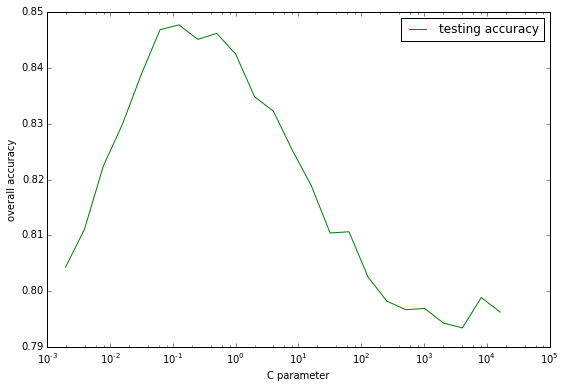

In [86]:
# Plot the figure with parameter C search 
cs = np.logspace(-9.0, 14.0, num=24, base=2)

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

ax.plot(cs, test_acc, 'g', label='testing accuracy')
ax.set_xscale('log')
handles, flabels = ax.get_legend_handles_labels()
ax.legend(handles, flabels)
ax.set_xlabel("C parameter")
ax.set_ylabel("overall accuracy")

fig.savefig('fig3.png')
fig.show()

Alright, we have found a set of parameters that provides better classification accuracy. Now let us compare the performances among the algorithms again:

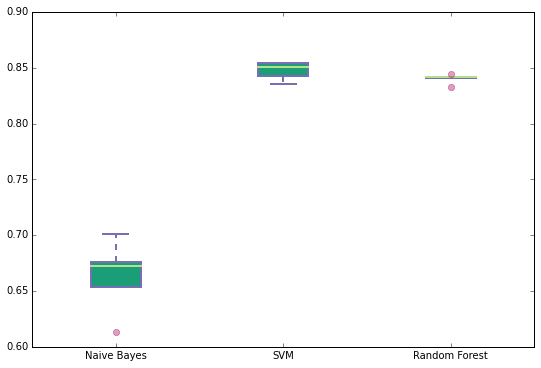

In [82]:
# run the SVM model with the newly found parameter set

svm = LinearSVC(C=0.0625, tol= 1.0 )

acc_svm = []
conf_svm = np.array([])
for train_index, test_index in skf:
    # for each fold in the dataset split, train the model according the training design matrix and label matrix
    svm.fit(X[train_index], labels[train_index])
    # obtain the predicted labels for testing dataset
    pred = svm.predict(X[test_index])
    acc_svm.append(accuracy_score(labels[test_index], pred, normalize=True))
    conf_svm = confusion_matrix(labels[test_index], pred)

# now plot the box plot again
data_to_plot = [acc_nb, acc_svm, acc_gbrt]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)
ax.set_xticklabels(['Naive Bayes', 'SVM', 'Random Forest'])

style_box(bp)

fig.savefig('fig2.png', bbox_inches='tight')

fig.show()

Now we see SVM performance is now slightly better. This small demonstration shows the importance of parameter tuning. 

##### Issue 2: Overfitting

Another thing to keep in mind is how generalizable your trained model is. One thing to avoid is naively trying to fit the training set, which results in a trained model that performs badly on testing dataset. This is called overfitting.

Say, for example, we test the parameter set on training set accuracy instead, then we would have C=1000000 as a good candidate. Test on testing data: 

In [25]:
svm = LinearSVC(C=1048576, tol=0.001)

acc_svm = []
acc_svm_train = []
conf_svm = np.array([])
for train_index, test_index in skf:
    # for each fold in the dataset split, train the model according the training design matrix and label matrix
    svm.fit(X[train_index], labels[train_index])
    # obtain the predicted labels for testing dataset
    pred = svm.predict(X[test_index])
    pred1 = svm.predict(X[train_index])
    acc_svm.append(accuracy_score(labels[test_index], pred, normalize=True))
    acc_svm_train.append(accuracy_score(labels[train_index], pred1, normalize=True))

print "training set accuracy: ", sum(acc_svm_train)/5.0
print "testing set accuracy: ", sum(acc_svm)/5.0

training set accuracy:  0.999672786761
testing set accuracy:  0.803226059916


We can observe the huge disparity between training and testing set accuracy. In fact, if we plot against varying parameter C, we can see this effect more closely. 

*Note: It's not necessary to run the script (plotting this requires running the parameter search script)

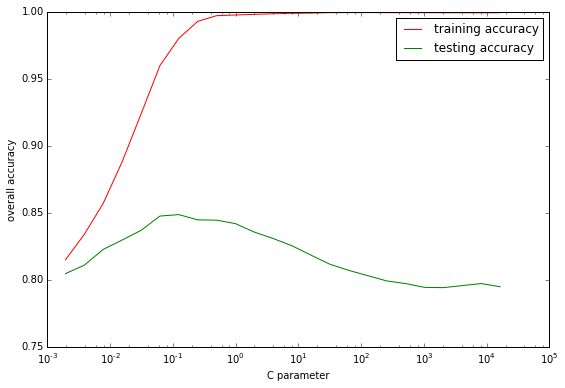

In [89]:
#Plot the training set accuracy against testing set accuracy
cs = np.logspace(-9.0, 14.0, num=24, base=2)

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

ax.plot(cs, train_acc, 'r', label='training accuracy')
ax.plot(cs, test_acc, 'g', label='testing accuracy')
ax.set_xscale('log')
handles, flabels = ax.get_legend_handles_labels()
ax.legend(handles, flabels)
ax.set_xlabel("C parameter")
ax.set_ylabel("overall accuracy")

fig.savefig('fig3.png')
fig.show()

##### Issue 3: Feature Selection & Pruning

Sometimes, it may be necessary to perform feature selection, due to the following reasons:

1. The feature dimension is too high and noisy 2. To understand better about feature performance.

If you know your dataset well, you can then perform some heuristic-based feature selection, like this (or stopword removal, etc.):

In [48]:
# filter url links by detecting http header
def filterHTTP(line):
    return ' '.join([w for w in line.split() if not 'http' in w[:4]])
words_nohttp = map(filterHTTP,words)

#check validity of result
print words[1]
print words_nohttp[1]

RT @pimentacom : #CPqD e #Microsoft testam opção para banda larga . Leia matéria que foi destaqu no Brasil Econômico : http://t.co/wImxVTlB
RT @pimentacom : #CPqD e #Microsoft testam opção para banda larga . Leia matéria que foi destaqu no Brasil Econômico :


You can also leverage the power of statistical models for feature selection. For example, we can calculate the chi-square score for the features for selection: 

In [61]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Generate a new design matrix with only the selected features as columns
kselect = SelectKBest(chi2, k=10)
X_new = kselect.fit_transform(X, labels)
# Print original design matrix dimension
print X.shape
# Print new design matrix dimension
print X_new.shape

# Print the top ranked words corresponding to selected features
fea = kselect.get_support(indices=True)
print np.array(vectorizer.get_feature_names())[fea]

(4584, 12881)
(4584, 10)
[u'appl' u'de' u'fail' u'fix' u'fuck' u'is' u'love' u'my' u'thank' u'the']


We can also just use the model itself to get the discriminative features for classification. Take Random Forest for example:

In [67]:
# Generate a new design matrix with only the significant features from the trained model

# Get the features that obtain higher importance feature score
importances = gbrt.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Print the top ranked words corresponding to selected features
print ""
print "Top scoring features:"
print np.array(vectorizer.get_feature_names())[indices[:20]]

Feature ranking:
1. feature 7274 (0.010169)
2. feature 1139 (0.009738)
3. feature 5638 (0.009285)
4. feature 6537 (0.009207)
5. feature 5164 (0.009155)
6. feature 2359 (0.008135)
7. feature 10643 (0.008063)
8. feature 10633 (0.007300)
9. feature 11021 (0.006510)
10. feature 4181 (0.006387)
11. feature 4350 (0.006319)
12. feature 4927 (0.006307)
13. feature 10792 (0.005803)
14. feature 1011 (0.005546)
15. feature 5666 (0.005230)
16. feature 4665 (0.005206)
17. feature 3480 (0.004986)
18. feature 11824 (0.004662)
19. feature 4252 (0.004316)
20. feature 1365 (0.004194)

Top scoring features:
[u'my' u'appl' u'is' u'love' u'http' u'co' u'the' u'thank' u'twitter'
 u'fix' u'fuck' u'hate' u'to' u'and' u'it' u'googl' u'eclips' u'with'
 u'for' u'awesom']
